<a href="https://colab.research.google.com/github/Renshui-MC/DeepLearning-ZerosToGans/blob/main/Training%20deep%20NN%20on%20GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Using GPU for training**
+ training on GPU can be a lot faster than that on CPU, e.g., minutes vs hours!!

+ we have to first enable the GPU option from "Runtime" 

## Preparing the Data

Recall that linear-regression logistic regression model is used to identify handwritten digits from the MNIST dataset with an accuracy of around 86%. The dataset consists of 28px by 28px grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents. Here are some sample images from the dataset:

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

We noticed that it's quite challenging to improve the accuracy of a logistic regression model beyond 87%, since the model assumes a **linear relationship** between **pixel intensities and image labels**.

In this post, we'll try to improve upon it  using a **feed-forward neural network** which can capture non-linear relationships between inputs and targets.

Let's begin by installing and importing the required modules and classes from `torch`, `torchvision`, `numpy`, and `matplotlib`.

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'


We can download the data and create a PyTorch dataset using the `MNIST` class from `torchvision.datasets`. 

+ `transform=ToTensor()`: images are downloaded as pytorch tensor shape: `1x28x28`(color channel, width, height)

+ `plt.imshow` is used to display the images. This object requirs **the color channel to be the last dimension in an image tensor**. so use `permute` method to reorder the dimensions of the images 

+ `root='data/'`: datasets are downloaded to the specified root


In [3]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



+ `image, label = dataset[0]` means the first image of the dataset: `image` contains $28 \times 28$ pixels

+ we check the original image shape, i.e., `image.shape` and gets `[1, 28, 28]`

+ `image.permute()` can be used to reorder the dimensions, e.g., `image.permute(1,2,0)` that puts the first dimension as the last dimension

In [4]:
image, label = dataset[0]
print(image.shape)
print(image.permute(1,2,0).shape) 
print(image[0].shape)                 

torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([28, 28])


use `image[0]` to remove the color channel dimension. Otherwise we will get an error message. 

image.shape: torch.Size([1, 28, 28])
Label: 5


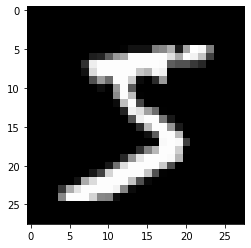

In [5]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image[0], cmap='gray')
print('Label:', label)

Next, let's use the `random_split` helper function to set aside $10000$ images for our **validation set**.

+ choose the size of the **validation set** 
+ choose the size of the **training set** 

In [6]:
len(dataset)

60000

In [9]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create `PyTorch` data loaders for **training and validation**.

+ specify the batch size = $128$ for `DataLoader`
+ `num_workers=4`: Setting the argument `num_workers` as a positive integer will turn on **multi-process data loading** with the specified number of loader worker processes
+ setting `pin_memory=True`, which enables fast data transfer to **CUDA-enabled GPUs**



In [11]:
batch_size = 128

In [12]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let's visualize a batch of data in a grid using the `make_grid` function from `torchvision`. 

+ `.permute` is needed to move the channel color dimension to the last dimension for `matplotlib` to work
+  `nrow` number of images displayed in each row of the grid
+ `grid.shape torch.Size([3, 242, 482])` ($242$ is height and $482$ is width) shows that the channel dimension is on the first index, and we need to move it to the last index to be compatible with `imshow`
+ $16 \times 8 = 128$ (a batch size)
+ `plt.figure(figsize=(16,8))` is just used to control the figure size. You can change `(16,8)` to a different pair to see how figure size changes
+ `nrow = 16` represents the number of columns in the output figure. Why $16$? While it can be any number, $16$ is chosen because $128$ is completely divisible by $16$. You can also set `nrow = 8` and the figure changes its shape of representation  


In [34]:
for images, _ in train_loader:
    print('image.shape:', images.shape)
    print('grid.shape', make_grid(images, nrow=16).shape)
    break

image.shape: torch.Size([128, 1, 28, 28])
grid.shape torch.Size([3, 242, 482])


images.shape: torch.Size([128, 1, 28, 28])


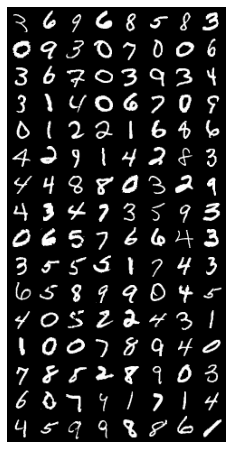

In [32]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

## **Hidden Layers, Activation Functions and Non-Linearity**

We'll create a neural network with two layers: a **hidden layer** and an **output layer**. Additionally, we'll use an **activation function** between the two layers 

+ how **hidden layers** and **activation functions** can help capture non-linear relationships between inputs and outputs

+ First, let's create a batch of inputs tensors. We'll flatten the `1x28x28` images into vectors of size `784`, so they can be passed into an `nn.Linear` object

1. `images` contains a set of batches 

2. Recall linear regression takes only a one-dimensional vector of each batch, therefore we have to convert $28 \times 28$ into $784$ (2D to 1D)

In [35]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    break

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


images.shape: torch.Size([128, 1, 28, 28])


In [36]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


Next, let's create a `nn.Linear` object as our **hidden layer**. 

+ We'll set the size of the output from the hidden layer to $32$. (This number can be increased or decreased to change the **learning capacity** of the model.)